<a href="https://colab.research.google.com/github/gyuchangShim/MJU_AI/blob/MASK-RCNN/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# detectron2 git clone 및 환경 설정
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15725, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 15725 (delta 201), reused 296 (delta 103), pack-reused 15277
Receiving objects: 100% (15725/15725), 6.51 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (11316/11316), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:0

In [2]:
# torch, cuda, detectron2 version 확인
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader

In [4]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

tf.test.is_gpu_available()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2925360954416632170
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12634915643673555715
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os
import json
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

# 파일 경로 설정
dataset_dir = "/content/gdrive/MyDrive/pole_dataset/"
images_path = os.path.join(dataset_dir, "images")
annotations_path = os.path.join(dataset_dir, "annotations", "instances_default.json")

# COCO 어노테이션 로드
coco = COCO(annotations_path)

# 모든 이미지 ID 가져오기
image_ids = list(coco.imgs.keys())

# 8:2 비율로 train, val 나누기
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

def create_coco_json(image_ids, coco, output_json_path):
    coco_dict = {
        "images": [],
        "annotations": [],
        "categories": coco.dataset["categories"]
    }
    for img_id in image_ids:
        coco_dict["images"].append(coco.imgs[img_id])
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        anns = coco.loadAnns(ann_ids)
        coco_dict["annotations"].extend(anns)
    with open(output_json_path, 'w') as f:
        json.dump(coco_dict, f)

# 새로운 어노테이션 파일 생성
train_annotations_output_path = os.path.join(dataset_dir, "annotations", "instances_train.json")
val_annotations_output_path = os.path.join(dataset_dir, "annotations", "instances_val.json")

create_coco_json(train_ids, coco, train_annotations_output_path)
create_coco_json(val_ids, coco, val_annotations_output_path)

# COCO 데이터셋 등록
train_images_path = images_path
val_images_path = images_path

register_coco_instances("pole_train", {}, train_annotations_output_path, train_images_path)
register_coco_instances("pole_val", {}, val_annotations_output_path, val_images_path)

# 데이터셋 메타데이터 로드
pole_metadata = MetadataCatalog.get("pole_train")
pole_val_metadata = MetadataCatalog.get("pole_val")

loading annotations into memory...
Done (t=2.75s)
creating index...
index created!


In [7]:
from detectron2.data import DatasetCatalog

# pole_train 데이터셋의 이미지 개수
train_dataset = DatasetCatalog.get("pole_train")
print(f"Number of images in pole_train: {len(train_dataset)}")

# pole_val 데이터셋의 이미지 개수
val_dataset = DatasetCatalog.get("pole_val")
print(f"Number of images in pole_val: {len(val_dataset)}")

[06/06 10:08:21 d2.data.datasets.coco]: Loading /content/gdrive/MyDrive/pole_dataset/annotations/instances_train.json takes 1.27 seconds.
[06/06 10:08:21 d2.data.datasets.coco]: Loaded 900 images in COCO format from /content/gdrive/MyDrive/pole_dataset/annotations/instances_train.json
Number of images in pole_train: 900
[06/06 10:08:21 d2.data.datasets.coco]: Loaded 226 images in COCO format from /content/gdrive/MyDrive/pole_dataset/annotations/instances_val.json
Number of images in pole_val: 226


In [20]:
# 기본 설정
cfg = get_cfg()
# COCO 데이터 셋에 사전 학습된 MASK R-CNN 모델의 기본 설정 파일 가져오기
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# 훈련 데이터 셋 지정
cfg.DATASETS.TRAIN = ("pole_train",)
# 모델 테스트 데이터 셋 지정
cfg.DATASETS.TEST = ("pole_val",)
# Data Loader에 필요한 worker 프로세스의 수 지정(많을 수록 빨라짐)
cfg.DATALOADER.NUM_WORKERS = 2
# COCO 데이터 셋에서 사전 학습된 모델의 가중치 가져오기(가중치 초기화)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 가중치 사용
# 한 Batch에 포함되는 이미지 개수 지정
cfg.SOLVER.IMS_PER_BATCH = 4
# 학습의 기본 학습률 설정(모델의 학습 속도를 결정)
cfg.SOLVER.BASE_LR = 0.00025
# 학습의 반복 횟수 지정
cfg.SOLVER.MAX_ITER = 200
# 각 이미지 당 ROI에서 추출할 샘플의 개수 지정(학습 중 사용)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
# 모델이 예측할 클래스 개수 지정
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(pole_metadata.thing_classes)

In [ ]:
# 이전 프로세스 확인
import psutil

for proc in psutil.process_iter():
    try:
        process_name = proc.name()
        if "python" in process_name and "colab" in process_name:
            print("이전 프로세스 발견:", process_name)
    except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
        pass

print("모든 프로세스 검색 완료.")

In [21]:
# CUDA 디버깅
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

# Trainer 생성
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 10:31:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/06 10:32:08 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 10:33:26 d2.utils.events]:  eta: 0:10:04  iter: 19  total_loss: 2.533  loss_cls: 1.589  loss_box_reg: 0.1847  loss_mask: 0.6918  loss_rpn_cls: 0.09151  loss_rpn_loc: 0.01772    time: 3.6873  last_time: 2.9699  data_time: 2.6958  last_data_time: 1.7877   lr: 2.3976e-05  max_mem: 14241M
[06/06 10:34:46 d2.utils.events]:  eta: 0:09:08  iter: 39  total_loss: 1.821  loss_cls: 0.9028  loss_box_reg: 0.1822  loss_mask: 0.682  loss_rpn_cls: 0.09572  loss_rpn_loc: 0.01821    time: 3.8394  last_time: 3.1129  data_time: 2.7209  last_data_time: 1.9484   lr: 4.8951e-05  max_mem: 14241M
[06/06 10:36:06 d2.utils.events]:  eta: 0:08:20  iter: 59  total_loss: 1.345  loss_cls: 0.3596  loss_box_reg: 0.1949  loss_mask: 0.6529  loss_rpn_cls: 0.08479  loss_rpn_loc: 0.01648    time: 3.8951  last_time: 2.7816  data_time: 2.7641  last_data_time: 1.8166   lr: 7.3926e-05  max_mem: 14241M
[06/06 10:37:25 d2.utils.events]:  eta: 0:07:09  iter: 79  total_loss: 1.252  loss_cls: 0.3229  loss_box_reg: 0.245  los

[06/06 10:46:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[06/06 10:46:15 d2.data.datasets.coco]: Loaded 226 images in COCO format from /content/gdrive/MyDrive/pole_dataset/annotations/instances_val.json


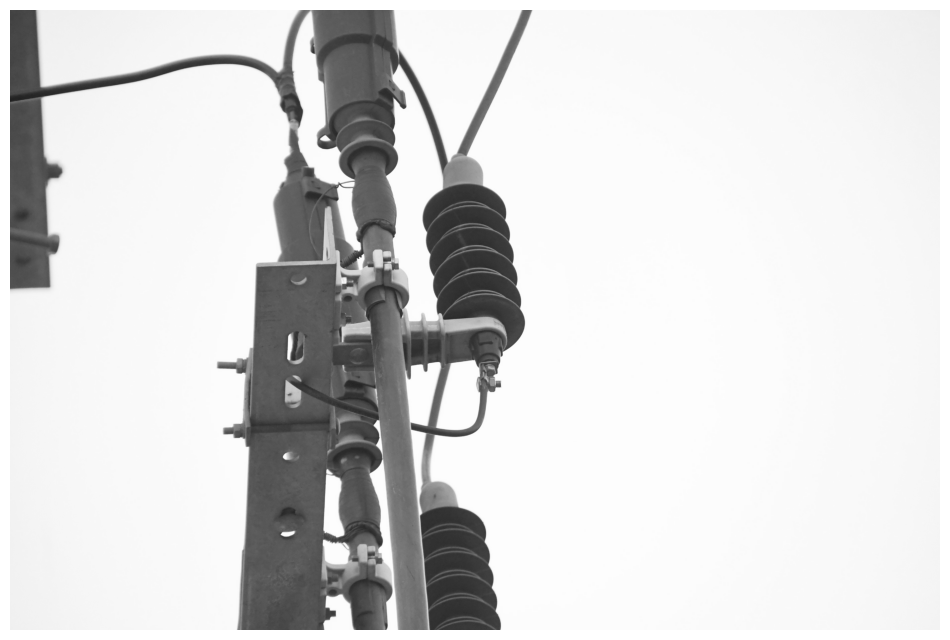

In [22]:
import random
import cv2
import torch
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo
import matplotlib.pyplot as plt

# Config 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pole_train",)
cfg.DATASETS.TEST = ("pole_val", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # 학습된 모델의 가중치 파일
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # 예측을 위한 임계값
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(pole_metadata.thing_classes)  # 클래스 수 설정
cfg.OUTPUT_DIR = "./output"

# 모델 로드
predictor = DefaultPredictor(cfg)

# 랜덤 이미지 선택 및 예측 결과 시각화 함수
def visualize_random_sample(dataset_name, predictor, metadata):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    random_sample = random.choice(dataset_dicts)
    img = cv2.imread(random_sample["file_name"])

    # 예측 수행
    outputs = predictor(img)

    # 시각화
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # 결과 이미지 출력 (Colab에서는 matplotlib을 사용)
    plt.figure(figsize=(12, 12))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# 유효성 검증 데이터에서 랜덤 이미지 시각화
visualize_random_sample("pole_val", predictor, pole_val_metadata)

# 테스트 데이터에서 랜덤 이미지 시각화
#visualize_random_sample("pole_test", predictor, pole_test_metadata)

In [ ]:
# Tensorboard를 활용한 결과 확인
%load_ext tensorboard
%tensorboard --logdir output